# Object Recognition & Orientation Detection
---
Zhiang Chen, Oct 2016

### 1. Import Packages

In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
import random
import operator
import time
import os

### 2. Import Data

In [26]:
image_size = 80

file_name = 'cropped_depth_data_numpy'
with open(file_name, 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    save = u.load()
    image_dict = save['image']
    del save

dataset = list()
str_classes = list()
angles = list()
for name,images in image_dict.items():
    [phase, obj, angle] = name.split('.')[0].split('-')
    for i in range(images.shape[0]):
        dataset.append(images[i,:,:])
        str_classes.append(obj)
        angles.append(int(angle))
        
name2value = {'v8':0,'duck':1,'stapler':2,'pball':3,'tball':4,'sponge':5,'bclip':6,'tape':7,'gstick':8,'cup':9,
              'pen':10,'calc':11,'blade':12,'bottle':13,'cpin':14,'scissors':15,'stape':16,'gball':17,'orwidg':18,
             'glue':19,'spoon':20,'fork':21,'nerf':22,'eraser':23,'empty':24}
name2string = {'v8':'v8 can','duck':'ducky','stapler':'stapler','pball':'ping pang ball','tball':'tennis ball','sponge':'sponge',
               'bclip':'binder clip','tape':'big tape','gstick':'glue stick','cup':'cup','pen':'pen','calc':'calculator',
               'blade':'razor','bottle':'bottle','cpin':'clothespin','scissors':'scissors','stape':'small tape','gball':'golf ball',
               'orwidg':'orange thing','glue':'glue','spoon':'spoon','fork':'fork','nerf':'nerf gun','eraser':'eraser',
               'empty':'empty plate'}
value2name = dict((value,name) for name,value in name2value.items())   

nm_image = len(dataset)
classes = [name2value[name] for name in str_classes]

dataset = np.asarray(dataset).astype(np.float32)
classes = np.asarray(classes)
angles = np.asarray(angles)/18%10


classes = (np.arange(len(name2value)) == classes[:,None]).astype(np.float32)
angles = (np.arange(10) == angles[:,None]).astype(np.float32)
labels = np.concatenate((classes,angles),axis=1)

In [29]:
o_dataset = list()
o_classes = list()
o_angles = list()
o_names = ['duck','stapler','sponge','bclip','pen','calc','blade','cpin','glue','scissors','spoon','fork','nerf','eraser']
for i in range(nm_image):
    if str_classes[i] in o_names:
        o_dataset.append(dataset[i,:,:])
        o_classes.append(classes[i,:])
        o_angles.append(angles[i,:])
        
o_dataset = np.asarray(o_dataset).astype(np.float32)
o_classes = np.asarray(o_classes)
o_angles = np.asarray(o_angles)

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.], dtype=float32)

### 3. Data Preprocess

In [20]:
def randomize(dataset, classes, angles):
    permutation = np.random.permutation(classes.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_classes = classes[permutation]
    shuffled_angles = angles[permutation]
    return shuffled_dataset, shuffled_classes, shuffled_angles

dataset, classes, angles = randomize(dataset, classes, angles)
o_dataset, o_classes, o_angles = randomize(o_dataset, o_classes, o_angles)

class: scissors
angle:  93


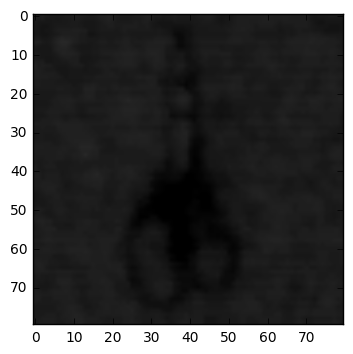

class: sponge
angle:  147


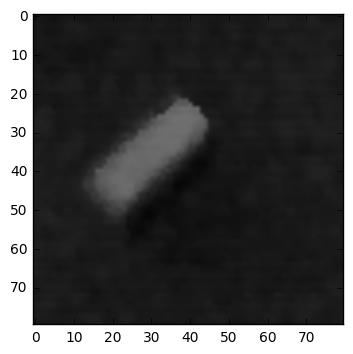

In [21]:
angle_bias = -15
indices = [random.randint(0,dataset.shape[0]) for x in range(2)]
for index in indices:
    image = dataset[index,:,:]
    print('class: %s' % value2name[np.argmax(classes[index])])
    print('angle: ',np.argmax(angles[index])*18 + angle_bias)
    plt.imshow(image,cmap='Greys_r',vmin=-0.6,vmax=0.4)
    plt.show()

class: bclip
angle:  129


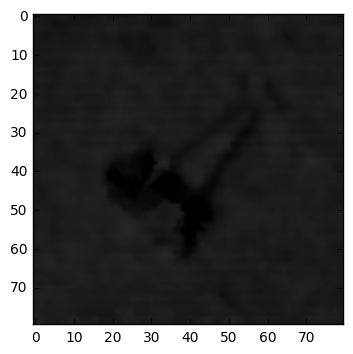

class: stapler
angle:  3


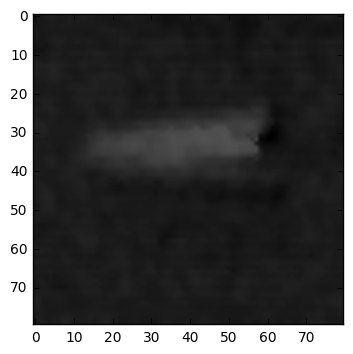

class: bclip
angle:  129


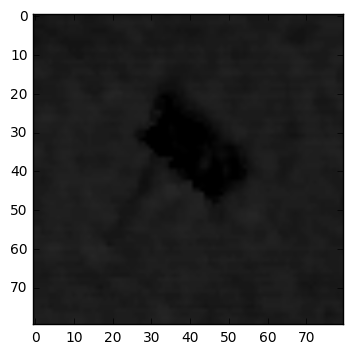

class: nerf
angle:  3


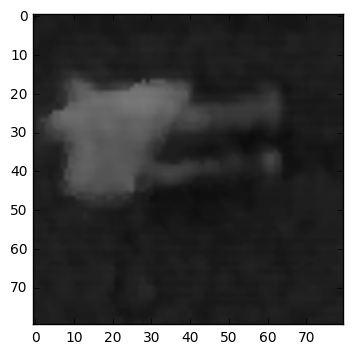

class: nerf
angle:  57


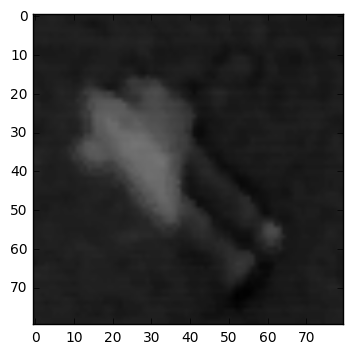

In [31]:
indices = [random.randint(0,o_dataset.shape[0]) for x in range(5)]
for index in indices:
    image = o_dataset[index,:,:]
    print('class: %s' % value2name[np.argmax(o_classes[index])])
    print('angle: ',np.argmax(o_angles[index])*18 + angle_bias)
    plt.imshow(image,cmap='Greys_r',vmin=-0.6,vmax=0.4)
    plt.show()

In [8]:
num_images = dataset.shape[0]
num_train = int(num_images*0.7)
num_valid = int(num_images*0.15)
num_test = int(num_images*0.15)

train_dataset = dataset[0:num_train,:,:].reshape(-1,image_size,image_size,1)
train_classes = classes[0:num_train,:]
train_angles = angles[0:num_train,:]

valid_dataset = dataset[num_train:(num_train+num_valid),:,:].reshape(-1,image_size,image_size,1)
valid_classes = classes[num_train:(num_train+num_valid),:]
valid_angles = angles[num_train:(num_train+num_valid),:]

test_dataset = dataset[(num_train+num_valid):,:,:].reshape(-1,image_size,image_size,1)
test_classes = classes[(num_train+num_valid):,:]
test_angles = angles[(num_train+num_valid):,:]

print('Training:', train_dataset.shape, train_classes.shape, train_angles.shape)
print('Validation:', valid_dataset.shape, valid_classes.shape, valid_angles.shape)
print('Testing:', test_dataset.shape, test_classes.shape, test_angles.shape)

Training: (5040, 80, 80, 1) (5040, 25) (5040, 10)
Validation: (1080, 80, 80, 1) (1080, 25) (1080, 10)
Testing: (1080, 80, 80, 1) (1080, 25) (1080, 10)


In [32]:
o_num_images = o_dataset.shape[0]
o_num_train = int(o_num_images*0.7)
o_num_valid = int(o_num_images*0.15)
o_num_test = int(o_num_images*0.15)

o_train_dataset = o_dataset[0:o_num_train,:,:].reshape(-1,image_size,image_size,1)
o_train_classes = o_classes[0:o_num_train,:]
o_train_angles = o_angles[0:o_num_train,:]

o_valid_dataset = o_dataset[o_num_train:(o_num_train+o_num_valid),:,:].reshape(-1,image_size,image_size,1)
o_valid_classes = o_classes[o_num_train:(o_num_train+o_num_valid),:]
o_valid_angles = o_angles[o_num_train:(o_num_train+o_num_valid),:]

o_test_dataset = o_dataset[(o_num_train+o_num_valid):,:,:].reshape(-1,image_size,image_size,1)
o_test_classes = o_classes[(o_num_train+o_num_valid):,:]
o_test_angles = o_angles[(o_num_train+o_num_valid):,:]

print('Training:', o_train_dataset.shape, o_train_classes.shape, o_train_angles.shape)
print('Validation:', o_valid_dataset.shape, o_valid_classes.shape, o_valid_angles.shape)
print('Testing:', o_test_dataset.shape, o_test_classes.shape, o_test_angles.shape)

Training: (3500, 80, 80, 1) (3500, 25) (3500, 10)
Validation: (750, 80, 80, 1) (750, 25) (750, 10)
Testing: (750, 80, 80, 1) (750, 25) (750, 10)


### 4. Define accuracy

In [63]:
def accuracy_classes(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def accuracy_angles(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def MSE_angles(predictions, labels):
  return np.mean((predictions-labels)**2)

### 5. Build Net

In [56]:
nm_classes = 25
nm_angles = 10
num_channels = 1 

batch_size = 30
patch_size = 5
kernel_size = 2
depth1 = 6
depth2 = 16 
depth3 = 10 
F7_classes = 120
F8_classes = 84
F9_classes = nm_classes
F7_angles = 120
F8_angles = 84
F9_angles = nm_angles

graph = tf.Graph()

with graph.as_default():
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    # convolution's input is a tensor of shape [batch,in_height,in_width,in_channels]
    tf_train_classes = tf.placeholder(tf.float32, shape=(batch_size, nm_classes))
    tf_train_angles = tf.placeholder(tf.float32, shape=(batch_size, nm_angles))
    
    tf_valid_dataset = tf.constant(o_valid_dataset)
    tf_test_dataset = tf.constant(o_test_dataset)
    
    # Variables(weights and biases)
    C1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1))
    # convolution's weights are called filter in tensorflow
    # it is a tensor of shape [kernel_hight,kernel_width,in_channels,out_channels]
    C1_biases = tf.Variable(tf.zeros([depth1]))
                            
    # S1_weights # Sub-sampling doesn't need weights and biases
    # S1_biases
    
    C3_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1))
    C3_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
                            
    # S4_weights
    # S4_biases
     
    C5_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, depth3], stddev=0.1))
    C5_biases = tf.Variable(tf.constant(1.0, shape=[depth3]))
    
    # S6_weights
    # S6_biases
    
    F7_classes_weights = tf.Variable(tf.truncated_normal([6 * 6 * depth3, F7_classes], stddev=0.1))
    F7_classes_biases = tf.Variable(tf.constant(1.0, shape=[F7_classes]))
    F7_angles_weights = tf.Variable(tf.truncated_normal([6 * 6 * depth3, F7_angles], stddev=0.1))
    F7_angles_biases = tf.Variable(tf.constant(1.0, shape=[F7_angles]))
    
    F8_classes_weights = tf.Variable(tf.truncated_normal([F7_classes,F8_classes], stddev=0.1))
    F8_classes_biases = tf.Variable(tf.constant(1.0, shape=[F8_classes]))
    F8_angles_weights = tf.Variable(tf.truncated_normal([F7_angles,F8_angles], stddev=0.1))
    F8_angles_biases = tf.Variable(tf.constant(1.0, shape=[F8_angles]))
    
    F9_classes_weights = tf.Variable(tf.truncated_normal([F8_classes,F9_classes], stddev=0.1))
    F9_classes_biases = tf.Variable(tf.constant(1.0, shape=[F9_classes]))
    F9_angles_weights = tf.Variable(tf.truncated_normal([F8_angles,F9_angles], stddev=0.1))
    F9_angles_biases = tf.Variable(tf.constant(1.0, shape=[F9_angles]))
    
    saver = tf.train.Saver()
    # Model
    def train_model(data):
        conv = tf.nn.conv2d(data, C1_weights, [1, 1, 1, 1], padding='VALID')
        hidden = tf.nn.relu(conv + C1_biases)
        
        max_pool = tf.nn.max_pool(hidden,[1,kernel_size,kernel_size,1],[1,2,2,1],'VALID')
        hidden = tf.nn.relu(max_pool)
                                
        conv = tf.nn.conv2d(hidden, C3_weights, [1, 1, 1, 1], padding='VALID')
        hidden = tf.nn.relu(conv + C3_biases)

        max_pool = tf.nn.max_pool(hidden,[1,kernel_size,kernel_size,1],[1,2,2,1],'VALID')
        hidden = tf.nn.relu(max_pool)
        
        conv = tf.nn.conv2d(hidden,C5_weights, [1,1,1,1], padding = 'VALID')
        hidden = tf.nn.relu(conv + C5_biases)

        max_pool = tf.nn.max_pool(hidden,[1,kernel_size,kernel_size,1],[1,2,2,1],'VALID')
        hidden = tf.nn.relu(max_pool)

        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden_classes = tf.nn.relu(tf.matmul(reshape, F7_classes_weights) + F7_classes_biases)
        hidden_angles = tf.nn.relu(tf.matmul(reshape, F7_angles_weights) + F7_angles_biases)
        
        fc_classes = tf.matmul(hidden_classes,F8_classes_weights)
        fc_angles = tf.matmul(hidden_angles,F8_angles_weights)
        hidden_classes = tf.nn.relu(fc_classes + F8_classes_biases)
        hidden_angles = tf.nn.relu(fc_angles + F8_angles_biases)
        
        fc_classes = tf.matmul(hidden_classes,F9_classes_weights)
        fc_angles = tf.matmul(hidden_angles,F9_angles_weights)
        output_classes = fc_classes + F9_classes_biases
        output_angles = fc_angles + F9_angles_biases
    
        return output_classes, output_angles
    
    def test_model(data):
        conv = tf.nn.conv2d(data, C1_weights, [1, 1, 1, 1], padding='VALID')
        hidden = tf.nn.relu(conv + C1_biases)
        
        max_pool = tf.nn.max_pool(hidden,[1,kernel_size,kernel_size,1],[1,2,2,1],'VALID')
        hidden = tf.nn.relu(max_pool)
                                
        conv = tf.nn.conv2d(hidden, C3_weights, [1, 1, 1, 1], padding='VALID')
        hidden = tf.nn.relu(conv + C3_biases)

        max_pool = tf.nn.max_pool(hidden,[1,kernel_size,kernel_size,1],[1,2,2,1],'VALID')
        hidden = tf.nn.relu(max_pool)
        
        conv = tf.nn.conv2d(hidden,C5_weights, [1,1,1,1], padding = 'VALID')
        hidden = tf.nn.relu(conv + C5_biases)

        max_pool = tf.nn.max_pool(hidden,[1,kernel_size,kernel_size,1],[1,2,2,1],'VALID')
        hidden = tf.nn.relu(max_pool)

        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden_classes = tf.nn.relu(tf.matmul(reshape, F7_classes_weights) + F7_classes_biases)
        hidden_angles = tf.nn.relu(tf.matmul(reshape, F7_angles_weights) + F7_angles_biases)
        
        fc_classes = tf.matmul(hidden_classes,F8_classes_weights)
        fc_angles = tf.matmul(hidden_angles,F8_angles_weights)
        hidden_classes = tf.nn.relu(fc_classes + F8_classes_biases)
        hidden_angles = tf.nn.relu(fc_angles + F8_angles_biases)
        
        fc_classes = tf.matmul(hidden_classes,F9_classes_weights)
        fc_angles = tf.matmul(hidden_angles,F9_angles_weights)
        output_classes = fc_classes + F9_classes_biases
        output_angles = fc_angles + F9_angles_biases
    
        return output_classes, output_angles
    
    # Training computation.
    logits_classes, logits_angles = train_model(tf_train_dataset)
    loss_classes = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_classes, tf_train_classes))
    loss_angles = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_angles, tf_train_angles))
    loss =  loss_angles #loss_classes +
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_classes_logits, train_angles_logits = test_model(tf_train_dataset)
    train_classes_prediction = tf.nn.softmax(logits_classes)
    train_angles_prediction = tf.nn.softmax(logits_angles)
    
    valid_classes_logits, valid_angles_logits = test_model(tf_valid_dataset)
    valid_classes_prediction = tf.nn.softmax(valid_classes_logits)
    valid_angles_prediction = tf.nn.softmax(valid_angles_logits)
    
    test_classes_logits, test_angles_logits = test_model(tf_test_dataset)
    test_classes_prediction = tf.nn.softmax(test_classes_logits)
    test_angles_prediction = tf.nn.softmax(test_angles_logits)

### 6. Train Net

In [64]:
## training
start_time = time.time()

num_steps = 200000
config = tf.ConfigProto()
config.log_device_placement = True
with tf.Session(graph=graph, config = config) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (o_train_classes.shape[0] - batch_size)
    batch_data = o_train_dataset[offset:(offset + batch_size), :, :, :]
    batch_classes = o_train_classes[offset:(offset + batch_size), :]
    batch_angles = o_train_angles[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_classes : batch_classes, tf_train_angles : batch_angles}
    _, l, classes_predictions, angles_predictions = session.run(
      [optimizer, loss, train_classes_prediction, train_angles_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      #print('Minibatch classes accuracy: %.1f%%' % accuracy_classes(classes_predictions, batch_classes))
      print('Minibatch angles accuracy: %.1f%%' % accuracy_angles(angles_predictions, batch_angles))
      #print('Validation classes accuracy: %.1f%%' % accuracy_classes(valid_classes_prediction.eval(), o_valid_classes))
      print('Validation angles accuracy: %.1f%%' % accuracy_angles(valid_angles_prediction.eval(), o_valid_angles))
      print('--------------------------------------')
  #print('Test classes accuracy: %.1f%%' % accuracy_classes(test_classes_prediction.eval(), o_test_classes))
  print('Test angles accuracy: %.1f%%' % accuracy_angles(test_angles_prediction.eval(), o_test_angles))
  end_time = time.time()
  duration = (end_time - start_time)/60
  print("Excution time: %0.2fmin" % duration)
  '''
  save_path = saver.save(session, "model.ckpt")
  print("Model saved in file: %s" % save_path)
  i_test = 0
  while(i_test!=''):
        i_test = input("Input an index of test image (or Enter to quit): ")
        label = test_labels[int(i_test),:].tolist()
        #print("Correct label: "+value2name[label.index(1)])
        image = test_dataset[int(i_test),:,:,:].reshape((-1,image_size,image_size,num_channels)).astype(np.float32)
        prediction = tf.nn.softmax(model(image))
        pre_dict = dict(zip(list(range(num_labels)),prediction.eval()[0]))
        sorted_pre_dict = sorted(pre_dict.items(), key=operator.itemgetter(1))
        name1 = value2name[sorted_pre_dict[-1][0]]
        name1 = name2string[name1]
        value1 = str(sorted_pre_dict[-1][1])
        name2 = value2name[sorted_pre_dict[-2][0]]
        name2 = name2string[name2]
        value2 = str(sorted_pre_dict[-2][1])
        tile = name1+': '+value1+'\n'+name2+': '+value2
        image = image.reshape((image_size,image_size)).astype(np.float32)
        plt.imshow(image,cmap='Greys_r')
        plt.suptitle(tile, fontsize=12)
        plt.xlabel(value2name[label.index(1)], fontsize=12)
        plt.show()
  '''

Initialized
Minibatch loss at step 0: 4.553339
Minibatch angles accuracy: 0.0%
Validation angles accuracy: 6.7%
--------------------------------------
Minibatch loss at step 1000: 2.407847
Minibatch angles accuracy: 0.0%
Validation angles accuracy: 14.4%
--------------------------------------
Minibatch loss at step 2000: 2.285619
Minibatch angles accuracy: 0.0%
Validation angles accuracy: 7.7%
--------------------------------------
Minibatch loss at step 3000: 2.373151
Minibatch angles accuracy: 0.0%
Validation angles accuracy: 6.7%
--------------------------------------
Minibatch loss at step 4000: 2.369880
Minibatch angles accuracy: 0.0%
Validation angles accuracy: 14.7%
--------------------------------------
Minibatch loss at step 5000: 2.348715
Minibatch angles accuracy: 0.0%
Validation angles accuracy: 6.7%
--------------------------------------
Minibatch loss at step 6000: 2.363432
Minibatch angles accuracy: 0.0%
Validation angles accuracy: 8.5%
----------------------------------

KeyboardInterrupt: 